# Vertical Strategy: Use text column to predict tex_paragraph column

## Outline
1. ✅ filter out stopwords in text column
    - word tokenize text column
2. ✅  use token match in big string to define candidate paragraphs
    - merge overlapping paragraphs
3. ✅ Score/rank paragraphs
    - some terms will be more relevant/weighted than others
    - also score them by requency
4. ✅ Check similarity between predicted paragraphs and actual paragraphs

In [7]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [21]:
import re

In [33]:
from collections import Counter

In [44]:
from bs4 import BeautifulSoup

In [70]:
from matplotlib import pyplot as plt

In [75]:
import numpy as np

In [360]:
from nltk.tokenize import sent_tokenize

In [103]:
# read in the vertical training subset
vert_training_subset_df = pd.read_csv('data/vertical_training_subset.csv', index_col=[0])
vert_training_subset_df.head(2)

,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text
0,A,0001090872-17-000018,Share Repurchase Authorization,The 2015 share repurchase program authorizes t...,1140000000,1.14,billions,"On May 28, 2015 we announced that our board ..."
1,A,0001090872-17-000018,Share Repurchase Intention,remaining authorization to repurchase up to,610000000,610.00,millions,"Table of Contents 2016, upon the completion ..."


In [118]:
set(vert_training_subset_df.data_key_friendly_name)

{'Share Repurchase Authorization',
 'Share Repurchase Intention',
 'Share Repurchase Utilization',
 'Unknown Share Repurchase Data'}

## collect all text cells into a string

In [10]:
text_list = [t.lower() for t in vert_training_subset_df.text]
len(text_list)

415

In [12]:
text_list[0:5]

['the 2015 share repurchase program authorizes the purchase of up to',
 'remaining authorization to repurchase up to',
 'share repurchase programs aggregating',
 'remained unused under a repurchase program',
 'remaining under its stock repurchase program as of december 30, 2017']

In [15]:
text_string = ''
for t in text_list:
    text_string = text_string + t + ' '

In [19]:
text_string[:500]

'the 2015 share repurchase program authorizes the purchase of up to remaining authorization to repurchase up to share repurchase programs aggregating remained unused under a repurchase program remaining under its stock repurchase program as of december 30, 2017 repurchase program share repurchase authorization utilized total authorized repurchased authorized the repurchase repurchased repurchased repurchase the company had repurchased a total of approximately august 2015 total stock repurchase au'

## tokenize text

In [26]:
text_tokens = [w for w in word_tokenize(text_string) if w.isalpha()]

In [29]:
text_tokens[0:10]

['the',
 'share',
 'repurchase',
 'program',
 'authorizes',
 'the',
 'purchase',
 'of',
 'up',
 'to']

In [39]:
# take out stop words
no_stops = [t for t in text_tokens if t not in stopwords.words('english')]

In [32]:
no_stops[0:10]

['share',
 'repurchase',
 'program',
 'authorizes',
 'purchase',
 'remaining',
 'authorization',
 'repurchase',
 'share',
 'repurchase']

In [258]:
# display 30 most frequent with their frequency
Counter(no_stops).most_common(30)

[('repurchase', 195),
 ('authorized', 142),
 ('board', 128),
 ('directors', 107),
 ('program', 83),
 ('share', 63),
 ('authorization', 51),
 ('total', 45),
 ('company', 44),
 ('remaining', 34),
 ('december', 32),
 ('additional', 30),
 ('approved', 29),
 ('stock', 23),
 ('shares', 22),
 ('purchase', 18),
 ('available', 18),
 ('remained', 17),
 ('repurchased', 16),
 ('common', 15),
 ('new', 15),
 ('announced', 14),
 ('plan', 12),
 ('authorizing', 12),
 ('aggregate', 12),
 ('repurchases', 12),
 ('authority', 11),
 ('cost', 7),
 ('increase', 6),
 ('purchased', 6)]

In [143]:
key_tokens = pd.DataFrame(Counter(no_stops).most_common(30))
key_tokens.columns = ['key_tok', 'kt_count']
key_tokens

,key_tok,kt_count
0,repurchase,195
1,authorized,142
2,board,128
3,directors,107
4,program,83
5,share,63
6,authorization,51
7,total,45
8,company,44
9,remaining,34


# 🤔 I could enhance my key_tokens by doing tf-idf
- between the text column and the the html text - the text column
    - which terms are prominent in text column that are not prominent in the rest of the html
    - which terms are prominent in the noisy signal that are not prominent in the noise?
- I could also enhance it by removing noisy words like 'total'

## Use text tokens to define paragraphs in a filing
For each html text
1. identify matches of tokens in the filing
2. define a paragraph as that tokens position plus and minus half the mean length of the paragraphs. 
3. if any paragraphs overlap, merge them into one

In [40]:
# read in an html
filing_path = 'data/nc_training_filings/0001193125-17-248016.html'
with open(filing_path) as file:
    file_html = file.read()

In [43]:
file_html[0:1000]

'<!DOCTYPE html>\n<html xmlns="http://www.w3.org/1999/xhtml">\n<head>\n<meta name="generator" content=\n"HTML Tidy for HTML5 (experimental) for Linux https://github.com/w3c/tidy-html5/tree/68a9e74" />\n<title>10-K</title>\n<title>EX-21.1</title>\n<title>EX-23.1</title>\n<title>EX-31.1</title>\n<title>EX-31.2</title>\n<title>EX-32.1</title>\n\n<style type="text/css">\n/*<![CDATA[*/\n body {\n  background-color: white;\n }\n p.c92 {font-family: Times New Roman; font-size: 80%; margin-bottom: 1px; margin-left: 1.00em; margin-top: 0px; text-indent: -1.00em}\n p.c91 {font-family: Times New Roman; font-size: 70%; text-align: left}\n p.c90 {font-family: Times New Roman; font-size: 80%; margin-bottom: 0px; margin-left: 1.00em; margin-top: 0px; text-indent: -1.00em}\n p.c89 {font-family: Times New Roman; font-size: 80%; margin-bottom: 1px; margin-top: 0px}\n p.c88 {font-family: Times New Roman; font-size: 80%; margin-bottom: 1px; margin-top: 0px; text-align: center}\n p.c87 {font-family: Times 

In [45]:
# filter out html and css
parsed_html = BeautifulSoup(file_html)

/Users/paulomartinez/anaconda3/lib/python3.6/site-packages/bs4/__init__.py:181: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 193 of the file /Users/paulomartinez/anaconda3/lib/python3.6/runpy.py. To get rid of this warning, change code that looks like this:

 BeautifulSoup(YOUR_MARKUP})

to this:

 BeautifulSoup(YOUR_MARKUP, "lxml")

  markup_type=markup_type))


In [49]:
parsed_html.body.text[0:500]

'\nTable of Contents\nUNITED STATES\nSECURITIES AND EXCHANGE COMMISSION\nWashington, D.C. 20549\n\nFORM 10-K\n\n[X] ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF\nTHE SECURITIES EXCHANGE ACT OF 1934\n\nFor the fiscal year ended June 30, 2017\n\nCommission file number: 001-15317\n\nRESMED INC.\n(Exact name of registrant as specified in its charter)\n\nDELAWARE\n(State or other jurisdiction of incorporation or organization)\n\n98-0152841\n(IRS Employer Identification No.)\n\n9001 Spectrum Center Blvd.\nSan Diego, CA 921'

In [57]:
print(parsed_html.body.text[0:300])


Table of Contents
UNITED STATES
SECURITIES AND EXCHANGE COMMISSION
Washington, D.C. 20549

FORM 10-K

[X] ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF
THE SECURITIES EXCHANGE ACT OF 1934

For the fiscal year ended June 30, 2017

Commission file number: 001-15317

RESMED INC.
(Exact name of regi


In [58]:
# convert filing to lower case
string_filing = parsed_html.body.text.lower()
print(string_filing[0:300])


table of contents
united states
securities and exchange commission
washington, d.c. 20549

form 10-k

[x] annual report pursuant to section 13 or 15(d) of
the securities exchange act of 1934

for the fiscal year ended june 30, 2017

commission file number: 001-15317

resmed inc.
(exact name of regi


In [59]:
# this code will find the index of the first match of a substring in a string
string_filing.index('commission')

57

In [60]:
string_filing[57]

'c'

In [162]:
# get the starting and ending index of a all substrings in string
tok_hits1 = [[m.start(),m.end()] for m in re.finditer('repurchase', string_filing)]
tok_hits1

[[158230, 158240],
 [158362, 158372],
 [158784, 158794],
 [158870, 158880],
 [158924, 158934],
 [159049, 159059],
 [167348, 167358],
 [167519, 167529],
 [167594, 167604],
 [187003, 187013],
 [191574, 191584],
 [191711, 191721],
 [294784, 294794],
 [294918, 294928],
 [295230, 295240],
 [295486, 295496],
 [295609, 295619],
 [295680, 295690],
 [295778, 295788],
 [295850, 295860],
 [295949, 295959],
 [296055, 296065],
 [296104, 296114],
 [296190, 296200],
 [296396, 296406],
 [296433, 296443]]

In [84]:
tok_hits1[0]

[158230, 158240]

In [85]:
tok_hits1[0][0]

158230

## define +- margin as standard deviation of paragraph length

In [79]:
par_lengths = [len(par) for par in vert_training_subset_df.paragraph_text]
par_lengths[0:10]

[565, 451, 884, 884, 520, 520, 359, 359, 1281, 436]

(array([ 79., 131., 100.,  56.,  28.,  11.,   6.,   2.,   0.,   2.]),
 array([  84. ,  329.2,  574.4,  819.6, 1064.8, 1310. , 1555.2, 1800.4,
        2045.6, 2290.8, 2536. ]),
 <a list of 10 Patch objects>)

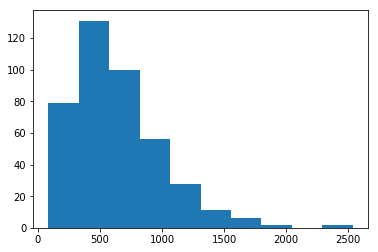

In [72]:
plt.hist(par_lengths)

In [76]:
np.mean(par_lengths)

640.6289156626506

In [77]:
np.median(par_lengths)

568.0

In [78]:
np.std(par_lengths)

366.2057912888913

In [92]:
int(np.std(par_lengths))

366

### define a paragraph as a slice centered at a *single* matched token +- half the median length of paragraphs

In [88]:
tok_hits1[0]

[158230, 158240]

In [93]:
# define paragraph with added margin
par1 = string_filing[tok_hits1[0][0] - int(np.std(par_lengths)) : tok_hits1[0][1] + int(np.std(par_lengths))]
par1

'pensation plans\n\nthe information included under item 12 of part iii of this report, "security ownership of\ncertain beneficial owners and management and related stockholder matters," is hereby incorporated by reference\ninto this item 5 of part ii of this report.\n\npurchases of equity securities\n\non february 21, 2014, our board of directors approved or current share repurchase program,\nauthorizing us to acquire up to an aggregate of 20 million shares of our common stock. the program allows us to\nrepurchase shares of our common stock from time to time for cash in the open market, or in negotiated or block\ntransactions, as market and business conditions warrant and subject to applicable legal requirements. there is\nno expiration date for'

In [ ]:
# instead of using two standard deviations to bound the paragraph
# I could use the preceding and following line breaks
# or I could do whichever comes first. 
# or sentences....

In [94]:
print(par1)

pensation plans

the information included under item 12 of part iii of this report, "security ownership of
certain beneficial owners and management and related stockholder matters," is hereby incorporated by reference
into this item 5 of part ii of this report.

purchases of equity securities

on february 21, 2014, our board of directors approved or current share repurchase program,
authorizing us to acquire up to an aggregate of 20 million shares of our common stock. the program allows us to
repurchase shares of our common stock from time to time for cash in the open market, or in negotiated or block
transactions, as market and business conditions warrant and subject to applicable legal requirements. there is
no expiration date for


## define a paragraph with token hit margins that overlap with eachother
### this strategy should be ♻️ 
- recyclable for a horizontal strategy that selects its key_tokens by tf_idf of the non-intersection of union(text and paragraph column) and html.

### collect and sort the start and end of each token
#### collect the start and end of each token in an ugly list of lists of tuples

In [328]:
# initialize a list of lists. each sublist will be the list of lists of token hits
lst_of_token_hits_lst = []

for i in range(len(key_tokens.key_tok[0:10])):
    kt = key_tokens.key_tok[i]
    print(kt)
    # generate list of token hits in big string
        # get the starting and ending index of a all substrings in string
    lst_of_token_hits_lst.append([(str(kt), m.start(),m.end()) for m in re.finditer(kt, string_filing)])

#print(lst_of_token_hits_lst[0][0:2])
#print(lst_of_token_hits_lst[1][0:2])
#print(lst_of_token_hits_lst[2][0:2])
lst_of_token_hits_lst[0:2]

repurchase
authorized
board
directors
program
share
authorization
total
company
remaining


[[('repurchase', 158230, 158240),
  ('repurchase', 158362, 158372),
  ('repurchase', 158784, 158794),
  ('repurchase', 158870, 158880),
  ('repurchase', 158924, 158934),
  ('repurchase', 159049, 159059),
  ('repurchase', 167348, 167358),
  ('repurchase', 167519, 167529),
  ('repurchase', 167594, 167604),
  ('repurchase', 187003, 187013),
  ('repurchase', 191574, 191584),
  ('repurchase', 191711, 191721),
  ('repurchase', 294784, 294794),
  ('repurchase', 294918, 294928),
  ('repurchase', 295230, 295240),
  ('repurchase', 295486, 295496),
  ('repurchase', 295609, 295619),
  ('repurchase', 295680, 295690),
  ('repurchase', 295778, 295788),
  ('repurchase', 295850, 295860),
  ('repurchase', 295949, 295959),
  ('repurchase', 296055, 296065),
  ('repurchase', 296104, 296114),
  ('repurchase', 296190, 296200),
  ('repurchase', 296396, 296406),
  ('repurchase', 296433, 296443)],
 [('authorized', 69077, 69087),
  ('authorized', 114586, 114596),
  ('authorized', 118758, 118768),
  ('authorized'

#### flatten the ugly list of lists of tuples, into a one-degree-less-ugly list of tuples

In [192]:
#### explanation of how the below list comprehension works
# for a list of lists
l = [['bob'], [1, 2, 3], [7], [8, 9], ['a', 'b']]

# use this list comprehension magic to flatten it by one degree
flat_list = [item for sublist in l for item in sublist]
print(flat_list)

# this is how the list comprehension reads when written as nested loops
flat_list = []
for sublist in l:
    for item in sublist:
        flat_list.append(item)
print(flat_list)

['bob', 1, 2, 3, 7, 8, 9, 'a', 'b']
['bob', 1, 2, 3, 7, 8, 9, 'a', 'b']


In [269]:
flater_list_of_tokhits = [tpl for sublist in lst_of_token_hits_lst for tpl in sublist]
flater_list_of_tokhits

[('repurchase', 158230, 158240),
 ('repurchase', 158362, 158372),
 ('repurchase', 158784, 158794),
 ('repurchase', 158870, 158880),
 ('repurchase', 158924, 158934),
 ('repurchase', 159049, 159059),
 ('repurchase', 167348, 167358),
 ('repurchase', 167519, 167529),
 ('repurchase', 167594, 167604),
 ('repurchase', 187003, 187013),
 ('repurchase', 191574, 191584),
 ('repurchase', 191711, 191721),
 ('repurchase', 294784, 294794),
 ('repurchase', 294918, 294928),
 ('repurchase', 295230, 295240),
 ('repurchase', 295486, 295496),
 ('repurchase', 295609, 295619),
 ('repurchase', 295680, 295690),
 ('repurchase', 295778, 295788),
 ('repurchase', 295850, 295860),
 ('repurchase', 295949, 295959),
 ('repurchase', 296055, 296065),
 ('repurchase', 296104, 296114),
 ('repurchase', 296190, 296200),
 ('repurchase', 296396, 296406),
 ('repurchase', 296433, 296443),
 ('authorized', 69077, 69087),
 ('authorized', 114586, 114596),
 ('authorized', 118758, 118768),
 ('authorized', 120454, 120464),
 ('authorize

#### order the list of token_hit indices by starting index

In [270]:
flater_list_of_tokhits.sort(key = lambda x: x[1])
flater_list_of_tokhits

[('company', 2416, 2423),
 ('company', 2446, 2453),
 ('company', 2545, 2552),
 ('company', 2576, 2583),
 ('company', 2717, 2724),
 ('company', 2745, 2752),
 ('company', 2780, 2787),
 ('company', 3071, 3078),
 ('directors', 3485, 3494),
 ('share', 3624, 3629),
 ('share', 3722, 3727),
 ('share', 3764, 3769),
 ('directors', 5109, 5118),
 ('company', 5725, 5732),
 ('company', 11012, 11019),
 ('share', 11595, 11600),
 ('total', 13643, 13648),
 ('program', 18392, 18399),
 ('board', 20218, 20223),
 ('program', 32287, 32294),
 ('total', 35266, 35271),
 ('program', 46193, 46200),
 ('program', 48880, 48887),
 ('directors', 48931, 48940),
 ('company', 50470, 50477),
 ('total', 50685, 50690),
 ('total', 51172, 51177),
 ('company', 53727, 53734),
 ('program', 57566, 57573),
 ('program', 58353, 58360),
 ('program', 60530, 60537),
 ('program', 60744, 60751),
 ('program', 61648, 61655),
 ('share', 65768, 65773),
 ('authorized', 69077, 69087),
 ('authorization', 69890, 69903),
 ('total', 73694, 73699),

### define paragraphs

In [271]:
margin = int(np.std(par_lengths))

In [242]:
'''# define the left bound of paragraph
left_bound_par1 = flater_list_of_tokhits[0][1] - margin
print(left_bound_par1)
print("")
# initialize the right bound of a pragraph
right_bound_par1 = flater_list_of_tokhits[0][2] + margin
print(right_bound_par1)
print('')

for i in range(1,len(flater_list_of_tokhits)):
# loop from the second token because we used the first token to define the left bound

    # if next tokens start is within par 1 bounds:
    if left_bound_par1 < flater_list_of_tokhits[i][1] < right_bound_par1:
        # expand right bounds margin from the end of next token
        right_bound_par1 = flater_list_of_tokhits[i][2] + margin
    
    # if next token is outside the margins of current paragraph, then it's time to start a new paragraph
    else:
        par1 = string_filing[left_bound_par1:right_bound_par1]
        position = i
        print('position = i', position)
        print('')
        print(par1)
        break'''

19852

20589

position = i 1

 increasing as a second-line option in patients unable to use cpap or those
with mild osa. these devices cause the mandible and tongue to be pulled forward and improve the dimensions of
the upper airway. cpap is a non-invasive means of treating osa. cpap was first used as
a treatment for osa in 1980 by dr. colin sullivan, the past chairman of our medical advisory board and was
commercialized for treatment of osa in the united states in the mid-1980s. during cpap
treatment, a patient sleeps with a nasal interface connected to a small portable air device that delivers room
air at a positive pressure. the patient breathes in air from the device and breathes out through an exhaust
port in the interface. continuous air pressure appl


In [240]:
'''# define the left bound of paragraph
left_bound_par2 = flater_list_of_tokhits[position][1] - margin
print(left_bound_par2)
print("")
# initialize the right bound of a pragraph
right_bound_par2 = flater_list_of_tokhits[position][2] + margin
print(right_bound_par2)
print('')

for i in range(position +1, len(flater_list_of_tokhits)):
# loop from the position + 1 token because we used the position token to define the left bound

    # if next tokens start is within par bounds:
    if left_bound_par2 < flater_list_of_tokhits[i][1] < right_bound_par2:
        # expand right bounds margin from the end of next token
        right_bound_par2 = flater_list_of_tokhits[i][2] + margin
    
    # if next token is outside the margins of current paragraph, then it's time to start a new paragraph
    else:
        par2 = string_filing[left_bound_par2:right_bound_par2]
        position = i
        print('position = i', position)
        print('')
        print(par2)
        break'''

68711

69453

position = i 2

egulates the design, development, research, preclinical and clinical
testing, introduction, manufacture, advertising, labeling, packaging, marketing, distribution, import and
export, and record keeping for such products, in order to ensure that medical products distributed in the
united states are safe and effective for their intended use. in addition, the fda is authorized to establish
special controls to provide reasonable assurance of the safety and effectiveness of most devices. non-compliance with applicable requirements can result in import detentions, fines, civil and
administrative penalties, injunctions, suspensions or losses of regulatory approvals, recall or seizure of
products, operating restrictions, refusal of the gove


In [272]:
len(flater_list_of_tokhits)

461

In [300]:
# initialize list of candidate paragraphs
candidate_paragraphs = []

# start at the beginning of the flater list of token hits
hit = 0

# work our way through the hits until we run out of hits
while hit < len(flater_list_of_tokhits)-1:
    print('')
    print('at hit value: ', hit)
    # define the left bound of a paragraph
    leftbound = flater_list_of_tokhits[hit][1] - margin
    print('-- defined leftbound to', leftbound)
    # initialize the right bound of a paragraph
    rightbound = flater_list_of_tokhits[hit][2] + margin
    print('-- initialized rightbound to', rightbound)
    
    # loop from the hit + 1 because we used the former hit to define the left bound
    print('---- >>entering loop at hit = ', hit)
    for i in range(hit + 1, len(flater_list_of_tokhits)):
        # if next token's start is within the current paragraphs bounds and we haven't exhausted the list of hits
        if (leftbound < flater_list_of_tokhits[i][1] < rightbound) and (i != len(flater_list_of_tokhits) - 1):
            # expand the right bound with respect to next token's end
            rightbound = flater_list_of_tokhits[i][2] + margin
            print('------ adjusted right bound to ', rightbound)
            print('-------- adjusted to the ith hit i = ', i, flater_list_of_tokhits[i])
            print('---------- now the rightbound = ', rightbound)
            
    # if next token is outside the bounds of current paragraph or we are at the penultimate hit
        else:
            print('defined paragraph ', len(candidate_paragraphs), '-------------------------')
            print("")
            # if right bound is out of index range, then adjust it to the end of the index
            if rightbound > len(string_filing):
                rightbound = len(string_filing)
            # define paragraph
            par = string_filing[leftbound:rightbound]
            # store the paragraph in a list of candidates
            candidate_paragraphs.append(par)
            # note which hit we need to start on for the next iteration of the while loop
            hit = i
            print('hit is now ', hit)
            print("- - - - - - - - - - - - - - - - - - ")
            print("")
            break

# this is just a repetition to handle the last hit
if hit == len(flater_list_of_tokhits)-1:
    print('at hit value: ', hit)
    # define the left bound of a paragraph
    leftbound = flater_list_of_tokhits[hit][1] - margin
    print('defined leftbound to', leftbound)
    # initialize the right bound of a paragraph
    rightbound = flater_list_of_tokhits[hit][2] + margin
    print('initialized rightbound to', rightbound)
    # if right bound is out of index range, then adjust it to the end of the index
    if rightbound > len(string_filing):
        rightbound = len(string_filing)
        print('adjusted right bound to end of string filing')
    print('defined paragraph ', len(candidate_paragraphs), '-------------------------')
    print("")
    # define paragraph
    par = string_filing[leftbound:rightbound]
    # store the paragraph in a list of candidates
    candidate_paragraphs.append(par)
    print("- - - - - - - - - - - - - - - - - - ")
    print("")


at hit value:  0
-- defined leftbound to 2050
-- initialized rightbound to 2789
---- >>entering loop at hit =  0
------ adjusted right bound to  2819
-------- adjusted to the ith hit i =  1 ('company', 2446, 2453)
---------- now the rightbound =  2819
------ adjusted right bound to  2918
-------- adjusted to the ith hit i =  2 ('company', 2545, 2552)
---------- now the rightbound =  2918
------ adjusted right bound to  2949
-------- adjusted to the ith hit i =  3 ('company', 2576, 2583)
---------- now the rightbound =  2949
------ adjusted right bound to  3090
-------- adjusted to the ith hit i =  4 ('company', 2717, 2724)
---------- now the rightbound =  3090
------ adjusted right bound to  3118
-------- adjusted to the ith hit i =  5 ('company', 2745, 2752)
---------- now the rightbound =  3118
------ adjusted right bound to  3153
-------- adjusted to the ith hit i =  6 ('company', 2780, 2787)
---------- now the rightbound =  3153
------ adjusted right bound to  3444
-------- adjust

defined paragraph  76 -------------------------

hit is now  193
- - - - - - - - - - - - - - - - - - 


at hit value:  193
-- defined leftbound to 213308
-- initialized rightbound to 214045
---- >>entering loop at hit =  193
------ adjusted right bound to  214374
-------- adjusted to the ith hit i =  194 ('total', 214003, 214008)
---------- now the rightbound =  214374
------ adjusted right bound to  214681
-------- adjusted to the ith hit i =  195 ('total', 214310, 214315)
---------- now the rightbound =  214681
------ adjusted right bound to  214985
-------- adjusted to the ith hit i =  196 ('total', 214614, 214619)
---------- now the rightbound =  214985
------ adjusted right bound to  215318
-------- adjusted to the ith hit i =  197 ('total', 214947, 214952)
---------- now the rightbound =  215318
defined paragraph  77 -------------------------

hit is now  198
- - - - - - - - - - - - - - - - - - 


at hit value:  198
-- defined leftbound to 215474
-- initialized rightbound to 2162

---- >>entering loop at hit =  404
defined paragraph  128 -------------------------

hit is now  405
- - - - - - - - - - - - - - - - - - 


at hit value:  405
-- defined leftbound to 314360
-- initialized rightbound to 315097
---- >>entering loop at hit =  405
------ adjusted right bound to  315357
-------- adjusted to the ith hit i =  406 ('company', 314984, 314991)
---------- now the rightbound =  315357
------ adjusted right bound to  315491
-------- adjusted to the ith hit i =  407 ('total', 315120, 315125)
---------- now the rightbound =  315491
------ adjusted right bound to  315726
-------- adjusted to the ith hit i =  408 ('company', 315353, 315360)
---------- now the rightbound =  315726
------ adjusted right bound to  315861
-------- adjusted to the ith hit i =  409 ('total', 315490, 315495)
---------- now the rightbound =  315861
defined paragraph  129 -------------------------

hit is now  410
- - - - - - - - - - - - - - - - - - 


at hit value:  410
-- defined leftbound to

In [301]:
len(candidate_paragraphs)

156

In [314]:
candidate_df = pd.DataFrame(candidate_paragraphs)
candidate_df.columns = ['cand_par']
candidate_df['len'] = [len(par) for par in candidate_df.cand_par]
candidate_df.sort_values(by = 'len', ascending = False, inplace=True)
candidate_df.reset_index(inplace=True, drop=True)
candidate_df

,cand_par,len
0,he revolving credit facility to pay off all ou...,4027
1,ing cash flows of $9.2 million and $14.5 milli...,2473
2,quivalent amount in australian currency based ...,2379
3,"sets\n\n\n$\n3,468,487\n\n\n$\n3,256,705\n\n\n...",2262
4,"ent expenses\n\n\n144,467\n\n\n\n118,651\n\n\n...",2239
5,\n\ngreat britain pound\n(gbp)\n\n\nchinese yu...,2010
6,"inancial reporting,\nassessing the risk that a...",1749
7,olidated financial statements and schedules - ...,1722
8,olidated financial statements and schedules - ...,1722
9,"968\n\n\n\n488,057\n\n\n\n478,627\n\n\n\n\nres...",1675


In [316]:
for i in range(5):
    print('index ', i, '--------------------------------------------------')
    print(candidate_df.cand_par[i])
    print("")

index  0 --------------------------------------------------
he revolving credit facility to pay off all outstanding amounts under
the term loan credit facility, in advance of the scheduled termination of the term loan credit facility on
april 3, 2017.

- f19 -


table of contents
resmed inc. and
subsidiaries
notes to consolidated financial statements



(12)

stockholders' equity



common stock. on february 21, 2014, our board of directors approved a new share
repurchase program, authorizing us to acquire up to an aggregate of 20.0 million shares of our common stock.
the program allows us to repurchase shares of our common stock from time to time for cash in the open market,
or in negotiated or block transactions, as market and business conditions warrant and subject to applicable
legal requirements. the 20.0 million shares the new program authorizes us to purchase are in addition to the
shares we repurchased on or before february 21, 2014 under our previous programs. there is no expi

### Looks like the longest paragraph is very relevant. Lets see if "repurchase" is in any of the other paragraphs

In [321]:
["repurchase" in par for par in candidate_df.cand_par]

[True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 Fals

In [324]:
candidate_df[["repurchase" in par for par in candidate_df.cand_par]]

,cand_par,len
0,he revolving credit facility to pay off all ou...,4027
2,quivalent amount in australian currency based ...,2379
13,"evenue in fiscal year 2017 increased to $2,066...",1463
14,y an additional tax expense relating to an inc...,1458
23,"0, 2016 of $547.9 million, which was\nprimaril...",1249


In [326]:
for par in candidate_df[["repurchase" in par for par in candidate_df.cand_par]].cand_par:
    print("====================================================")
    print(par)
    print('===================================================')
    print("")

he revolving credit facility to pay off all outstanding amounts under
the term loan credit facility, in advance of the scheduled termination of the term loan credit facility on
april 3, 2017.

- f19 -


table of contents
resmed inc. and
subsidiaries
notes to consolidated financial statements



(12)

stockholders' equity



common stock. on february 21, 2014, our board of directors approved a new share
repurchase program, authorizing us to acquire up to an aggregate of 20.0 million shares of our common stock.
the program allows us to repurchase shares of our common stock from time to time for cash in the open market,
or in negotiated or block transactions, as market and business conditions warrant and subject to applicable
legal requirements. the 20.0 million shares the new program authorizes us to purchase are in addition to the
shares we repurchased on or before february 21, 2014 under our previous programs. there is no expiration date
for this program, and the program may be acceler

## For now, ranking paragraphs by something as unrefined as brute length is working well (for this one test case)
### filtering the candidate paragraphs to those containing 'repurchase' worked well too. 

## 🤔 💡 
#### can enhance by counting how many key_token hits each paragraph has
#### can enhance by assigning weighted values to certain key_tokens

# Next step is to validate my results
- is the original row's text in the paragraph I "nominated?"
- is the original row's paragraph in the paragraph I "nominated?"


In [329]:
filing_path

'data/nc_training_filings/0001193125-17-248016.html'

In [330]:
vert_training_subset_df

,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text
0,A,0001090872-17-000018,Share Repurchase Authorization,The 2015 share repurchase program authorizes t...,1140000000,1.14,billions,"On May 28, 2015 we announced that our board ..."
1,A,0001090872-17-000018,Share Repurchase Intention,remaining authorization to repurchase up to,610000000,610.00,millions,"Table of Contents 2016, upon the completion ..."
2,AAL,0000006201-18-000009,Share Repurchase Authorization,share repurchase programs aggregating,11000000000,11.00,billions,4. Share Repurchase Programs and Dividends S...
3,AAL,0000006201-18-000009,Share Repurchase Intention,remained unused under a repurchase program,450000000,450.00,millions,4. Share Repurchase Programs and Dividends S...
4,AAP,0001158449-18-000039,Share Repurchase Intention,remaining under its stock repurchase program a...,415100000,415.10,millions,The Company's stock repurchase program allows ...
5,AAP,0001158449-18-000039,Share Repurchase Authorization,repurchase program,500000000,500.00,millions,The Company's stock repurchase program allows ...
6,AAPL,0000320193-17-000070,Share Repurchase Authorization,share repurchase authorization,210000000000,210.00,billions,"Share Repurchase Program In May 2017, the Co..."
7,AAPL,0000320193-17-000070,Share Repurchase Utilization,utilized,166000000000,166.00,billions,"Share Repurchase Program In May 2017, the Co..."
8,AAPL,0000320193-17-000070,Share Repurchase Intention,Total,44023000000,44023.00,millions,Total Number of Approximate Dollar Valu...
9,ABBV,0001551152-18-000014,Share Repurchase Authorization,authorized,10000000000,10.00,billions,"On February 15, 2018, AbbVie's board of direct..."


In [333]:
vert_training_subset_df[['0001193125-17-248016' in an for an in vert_training_subset_df.accession_number]]

,ticker,accession_number,data_key_friendly_name,text,data_value,reported_data_value,reported_units,paragraph_text
327,RMD,0001193125-17-248016,Unknown Share Repurchase Data,additional shares can be repurchased under the...,13600000,13.6,millions,"As noted above, we did not repurchase any shar..."


In [336]:
candidate_df.head(3)

,cand_par,len
0,he revolving credit facility to pay off all ou...,4027
1,ing cash flows of $9.2 million and $14.5 milli...,2473
2,quivalent amount in australian currency based ...,2379


In [350]:
vert_training_subset_df.loc[327].text

'additional shares can be repurchased under the approved share repurchase program'

In [348]:
[vert_training_subset_df.loc[327].text in cp for cp in candidate_df.cand_par[0:3]]

[True, False, False]

In [354]:
[vert_training_subset_df.loc[327].paragraph_text.lower() in cp for cp in candidate_df.cand_par[0:3]]

[False, False, False]

In [353]:
vert_training_subset_df.loc[327].paragraph_text.lower()

'as noted above, we did not repurchase any shares during the year ended june 30, 2017. during the year ended   june 30, 2016, we repurchased 1.9 million shares at a cost of $102.1 million prior to the temporary   suspension of the share repurchase program. as of june 30, 2017, we have repurchased a total of 41.1 million   shares at a cost of $1.5 billion. shares that are repurchased are classified as "treasury stock pending   future use" and reduce the number of shares outstanding used in calculating earnings per share. at june 30,   2017, 13.6 million additional shares can be repurchased under the approved share repurchase program'

In [355]:
print(candidate_df.cand_par[0])

he revolving credit facility to pay off all outstanding amounts under
the term loan credit facility, in advance of the scheduled termination of the term loan credit facility on
april 3, 2017.

- f19 -


table of contents
resmed inc. and
subsidiaries
notes to consolidated financial statements



(12)

stockholders' equity



common stock. on february 21, 2014, our board of directors approved a new share
repurchase program, authorizing us to acquire up to an aggregate of 20.0 million shares of our common stock.
the program allows us to repurchase shares of our common stock from time to time for cash in the open market,
or in negotiated or block transactions, as market and business conditions warrant and subject to applicable
legal requirements. the 20.0 million shares the new program authorizes us to purchase are in addition to the
shares we repurchased on or before february 21, 2014 under our previous programs. there is no expiration date
for this program, and the program may be acceler

It is contained in it, but the problem is they are formatted differently. I'd probably have to convert the paragraphs to be compared into tokenized bags of words or something. 
- or I'd have to clean them with regex

### attempt to compare with sentence tokenization

In [362]:
type(sent_tokenize(vert_training_subset_df.loc[327].paragraph_text.lower()))

list

In [363]:
sent_tokenize(vert_training_subset_df.loc[327].paragraph_text.lower())

['as noted above, we did not repurchase any shares during the year ended june 30, 2017. during the year ended   june 30, 2016, we repurchased 1.9 million shares at a cost of $102.1 million prior to the temporary   suspension of the share repurchase program.',
 'as of june 30, 2017, we have repurchased a total of 41.1 million   shares at a cost of $1.5 billion.',
 'shares that are repurchased are classified as "treasury stock pending   future use" and reduce the number of shares outstanding used in calculating earnings per share.',
 'at june 30,   2017, 13.6 million additional shares can be repurchased under the approved share repurchase program']

In [365]:
sent_tokenize(candidate_df.cand_par[0])

['he revolving credit facility to pay off all outstanding amounts under\nthe term loan credit facility, in advance of the scheduled termination of the term loan credit facility on\napril 3, 2017.',
 "- f19 -\n\n\ntable of contents\nresmed inc. and\nsubsidiaries\nnotes to consolidated financial statements\n\n\n\n(12)\n\nstockholders' equity\n\n\n\ncommon stock.",
 'on february 21, 2014, our board of directors approved a new share\nrepurchase program, authorizing us to acquire up to an aggregate of 20.0 million shares of our common stock.',
 'the program allows us to repurchase shares of our common stock from time to time for cash in the open market,\nor in negotiated or block transactions, as market and business conditions warrant and subject to applicable\nlegal requirements.',
 'the 20.0 million shares the new program authorizes us to purchase are in addition to the\nshares we repurchased on or before february 21, 2014 under our previous programs.',
 'there is no expiration date\nfor 

### attempt to compare with word tokenization

In [367]:
word_tokenize(vert_training_subset_df.loc[327].paragraph_text.lower())

['as',
 'noted',
 'above',
 ',',
 'we',
 'did',
 'not',
 'repurchase',
 'any',
 'shares',
 'during',
 'the',
 'year',
 'ended',
 'june',
 '30',
 ',',
 '2017.',
 'during',
 'the',
 'year',
 'ended',
 'june',
 '30',
 ',',
 '2016',
 ',',
 'we',
 'repurchased',
 '1.9',
 'million',
 'shares',
 'at',
 'a',
 'cost',
 'of',
 '$',
 '102.1',
 'million',
 'prior',
 'to',
 'the',
 'temporary',
 'suspension',
 'of',
 'the',
 'share',
 'repurchase',
 'program',
 '.',
 'as',
 'of',
 'june',
 '30',
 ',',
 '2017',
 ',',
 'we',
 'have',
 'repurchased',
 'a',
 'total',
 'of',
 '41.1',
 'million',
 'shares',
 'at',
 'a',
 'cost',
 'of',
 '$',
 '1.5',
 'billion',
 '.',
 'shares',
 'that',
 'are',
 'repurchased',
 'are',
 'classified',
 'as',
 '``',
 'treasury',
 'stock',
 'pending',
 'future',
 'use',
 "''",
 'and',
 'reduce',
 'the',
 'number',
 'of',
 'shares',
 'outstanding',
 'used',
 'in',
 'calculating',
 'earnings',
 'per',
 'share',
 '.',
 'at',
 'june',
 '30',
 ',',
 '2017',
 ',',
 '13.6',
 'milli

In [366]:
word_tokenize(candidate_df.cand_par[0])

['he',
 'revolving',
 'credit',
 'facility',
 'to',
 'pay',
 'off',
 'all',
 'outstanding',
 'amounts',
 'under',
 'the',
 'term',
 'loan',
 'credit',
 'facility',
 ',',
 'in',
 'advance',
 'of',
 'the',
 'scheduled',
 'termination',
 'of',
 'the',
 'term',
 'loan',
 'credit',
 'facility',
 'on',
 'april',
 '3',
 ',',
 '2017',
 '.',
 '-',
 'f19',
 '-',
 'table',
 'of',
 'contents',
 'resmed',
 'inc.',
 'and',
 'subsidiaries',
 'notes',
 'to',
 'consolidated',
 'financial',
 'statements',
 '(',
 '12',
 ')',
 'stockholders',
 "'",
 'equity',
 'common',
 'stock',
 '.',
 'on',
 'february',
 '21',
 ',',
 '2014',
 ',',
 'our',
 'board',
 'of',
 'directors',
 'approved',
 'a',
 'new',
 'share',
 'repurchase',
 'program',
 ',',
 'authorizing',
 'us',
 'to',
 'acquire',
 'up',
 'to',
 'an',
 'aggregate',
 'of',
 '20.0',
 'million',
 'shares',
 'of',
 'our',
 'common',
 'stock',
 '.',
 'the',
 'program',
 'allows',
 'us',
 'to',
 'repurchase',
 'shares',
 'of',
 'our',
 'common',
 'stock',
 'fro

In [369]:
len(word_tokenize(vert_training_subset_df.loc[327].paragraph_text.lower()))

121

In [371]:
counter = 0
for wt in word_tokenize(vert_training_subset_df.loc[327].paragraph_text.lower()):
    if wt in word_tokenize(candidate_df.cand_par[0]):
        counter += 1
print(counter)

121


### the above code confirms every single word token from the csv is in my candidate paragraph.
- but that is a sloppy verification process.

## attempt to verify string for string with spacy

In [372]:
import spacy

In [373]:
nlp = spacy.load('en')
nlp.entity

In [377]:
nominated = nlp(candidate_df.cand_par[0])
nominated[0:200]

he revolving credit facility to pay off all outstanding amounts under
the term loan credit facility, in advance of the scheduled termination of the term loan credit facility on
april 3, 2017.

- f19 -


table of contents
resmed inc. and
subsidiaries
notes to consolidated financial statements



(12)

stockholders' equity



common stock. on february 21, 2014, our board of directors approved a new share
repurchase program, authorizing us to acquire up to an aggregate of 20.0 million shares of our common stock.
the program allows us to repurchase shares of our common stock from time to time for cash in the open market,
or in negotiated or block transactions, as market and business conditions warrant and subject to applicable
legal requirements. the 20.0 million shares the new program authorizes us to purchase are in addition to the
shares we repurchased on or before february 21, 2014 under our previous programs. there is no expiration date
for this program, and the program may be acceler

that didn't work. spacy's nlp is preserving the new line breaks. 
- I guess it's time to bust out the regex and just replace the new lines with spaces.

In [384]:
nominated = re.sub(r'\n+', ' ',candidate_df.cand_par[0]) #remove all the new lines
nominated = re.sub(r'\s+', ' ', nominated) #trim all spaces to a single space
nominated

'he revolving credit facility to pay off all outstanding amounts under the term loan credit facility, in advance of the scheduled termination of the term loan credit facility on april 3, 2017. - f19 - table of contents resmed inc. and subsidiaries notes to consolidated financial statements (12) stockholders\' equity common stock. on february 21, 2014, our board of directors approved a new share repurchase program, authorizing us to acquire up to an aggregate of 20.0 million shares of our common stock. the program allows us to repurchase shares of our common stock from time to time for cash in the open market, or in negotiated or block transactions, as market and business conditions warrant and subject to applicable legal requirements. the 20.0 million shares the new program authorizes us to purchase are in addition to the shares we repurchased on or before february 21, 2014 under our previous programs. there is no expiration date for this program, and the program may be accelerated, su

In [385]:
vert_training_subset_df.loc[327].paragraph_text.lower()

'as noted above, we did not repurchase any shares during the year ended june 30, 2017. during the year ended   june 30, 2016, we repurchased 1.9 million shares at a cost of $102.1 million prior to the temporary   suspension of the share repurchase program. as of june 30, 2017, we have repurchased a total of 41.1 million   shares at a cost of $1.5 billion. shares that are repurchased are classified as "treasury stock pending   future use" and reduce the number of shares outstanding used in calculating earnings per share. at june 30,   2017, 13.6 million additional shares can be repurchased under the approved share repurchase program'

In [388]:
(vert_training_subset_df.loc[327].paragraph_text.lower()) in nominated

False

In [391]:
re.sub(r'\s+', ' ', vert_training_subset_df.loc[327].paragraph_text.lower()) in nominated

True

# Success!!! 😄 😎🐍🌟🎉